# Exercise: Chicago Food Deserts

#### Summary

Looking at census tracts in Chicago to find food deserts - places without a good source of food.

#### Data Source(s)

All data from the city of Chicago

#### Files

- `Boundaries - Census Tracts - 2010.zip`, census tracts in Chicago from [here](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Census-Tracts-2010/5jrd-6zik)
- `Grocery_Stores_-_2013.csv`, grocery stores in Chicago from [here](https://data.cityofchicago.org/Community-Economic-Development/Grocery-Stores-2013/53t8-wyrc)

#### Data dictionary

Visit the "here" links above. Scroll down a little and click 'Show All' to see every column.

#### Skills

- Opening shapefiles
- Opening CSV files as geography
- Reprojecting
- Buffers

## Import what you'll need to do geographic work

Probably pandas, geopandas, and the shapely thing that lets you make Points

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
%matplotlib inline

## Read in the census tract boundaries for Chicago

Give it a name that makes sense, like `tracts`.

In [8]:
tracts = gpd.read_file("Boundaries - Census Tracts - 2010/geo_export_085dcd7b-113c-4a6d-8d43-5926de1dcc5b.shp")
tracts.head(2)

,commarea,commarea_n,countyfp10,geoid10,geometry,name10,namelsad10,notes,statefp10,tractce10
0,44,44.0,031,17031842400,POLYGON ((-87.62404799998049 41.73021699998396...,8424,Census Tract 8424,None,17,842400
1,59,59.0,031,17031840300,"POLYGON ((-87.6860799999848 41.82295600001154,...",8403,Census Tract 8403,None,17,840300


### Confirm that you have 10 columns and 801 rows

In [9]:
tracts.shape

(801, 10)

### What does the data look like? What columns do you have?

In [10]:
tracts.dtypes

commarea       object
commarea_n    float64
countyfp10     object
geoid10        object
geometry       object
name10         object
namelsad10     object
notes          object
statefp10      object
tractce10      object
dtype: object

### Plot it to see if it looks okay

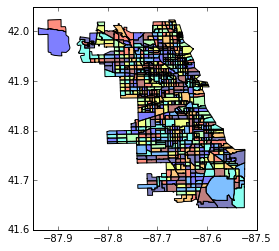

In [11]:
tracts.plot()

## Read in the grocery store data for Chicago

Note that you'll be reading in a **csv, not a shapefile**. This takes an extra conversion step to turn it into a GeoDataFrame - hopefully you have an easy cut-and-paste from last class!

Give it a name that makes sense, like `grocery_stores`.

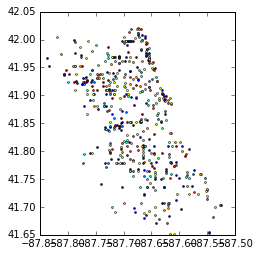

In [17]:
# STEP ONE: read it in as a normal dataframe
# STEP TWO: Take the lon/lat pairs and turn them into points
# STEP THREE: Create a GeoDataFrame from your old DataFrame,
# adding in your brand-new points as a geometry column
# STEP FOUR: Hey!!! I'm just gonna GIVE you a CRS i invented
df = pd.read_csv("Grocery_Stores_-_2013.csv")

points = df.apply(lambda row: Point(row.LONGITUDE, row.LATITUDE), axis=1)
grocery_stores = gpd.GeoDataFrame(df, geometry=points)
grocery_stores.crs = {'init': 'epsg:4326'}
grocery_stores.plot()

### Confirm that you have 506 rows

In [18]:
grocery_stores.shape

(506, 18)

### Plot to make sure it looks okay

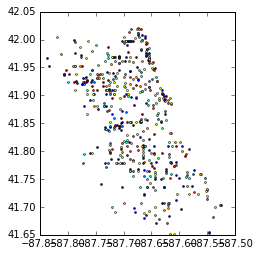

In [19]:
grocery_stores.plot()

## Plot the grocery stores on top of the census tracts.

- Make it look somewhat nice, with a nice grey background and grocery stores that stand out.
- Be sure the CRSes are the same!

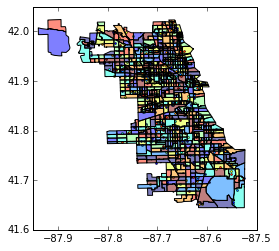

In [21]:
ax = grocery_stores.plot()
tracts.plot(ax=ax)

(-87.950000000000003, -87.5, 41.600000000000001, 42.050000000000004)

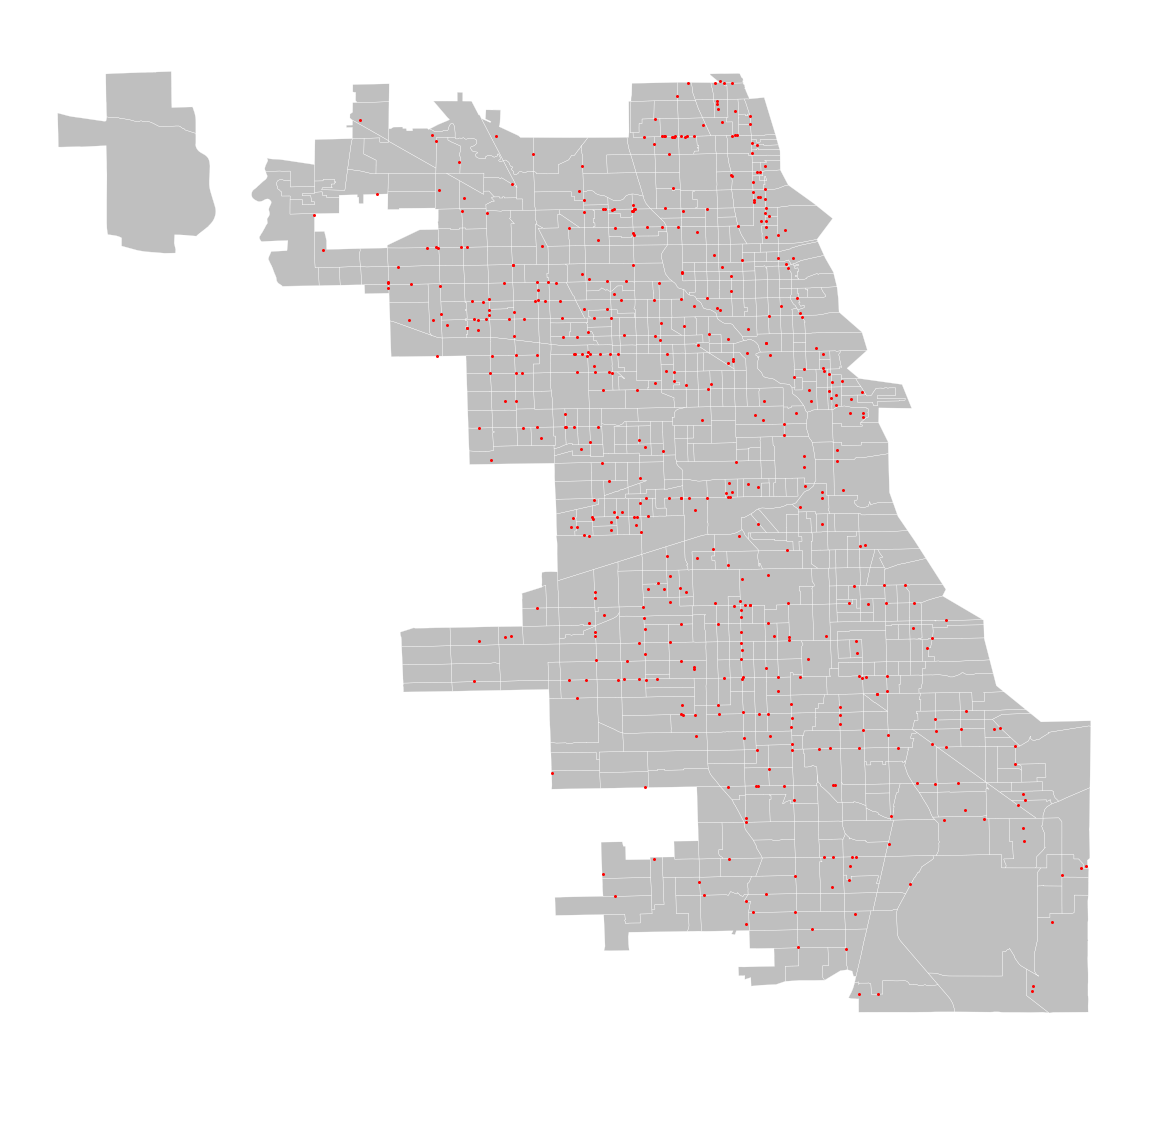

In [35]:
ax = tracts.plot(figsize=(20,20), color='grey', linewidth=0.25, edgecolor='white')
grocery_stores.plot(ax=ax, color='red', markeredgewidth=0, markersize=3)
ax.axis('off')

## Which census tracts don't have a grocery store?

Just in case you forgot, `~` means "does NOT" in pandas. So for example, you might think the following code means **"plot all of the tracts that do NOT contain a grocery store"**.

```pyhon
tracts[~tracts.contains(grocery_stores)].plot()
```

Try it. It doesn't work.

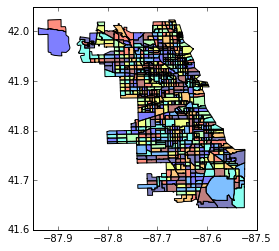

In [30]:
tracts.plot()

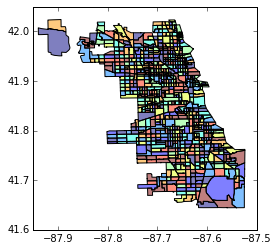

In [29]:
tracts[~tracts.contains(grocery_stores)].plot()

It actually means **"plot all of the tracts that do not contain *every* grocery store"**. Since no census tract contains every grocery store, it won't work.

## Geographic relationships

There are [a lot of other spatial relationships](http://geopandas.org/reference.html), such as:

Versions that makes sense:

* **contains:** has the other object TOTALLY INSIDE  (boundaries can't touch!!!) "a neighborhood CONTAINS restaurants"
* **intersects:** is OVERLAPPING at ALL, unless it's just boundaries touching
* **touches:** only the boundaries touch, like a tangent
* **within:** is TOTALLY INSIDE of the other object "a restaurant is WITHIN a neighborhood"
* **disjoint:** no touching!!! no intersecting!!!!
* **crosses:** goes through but isn't inside - "a river crossing through a city"

Nonsense version:

* **contains:** each object’s interior contains the boundary and interior of the other object and their boundaries do not touch at all
* **intersects:** the boundary and interior of each object intersects in any way with those of the other
* **touches:** if the objects have at least one point in common and their interiors do not intersect with any part of the other
* **within:** if each object’s boundary and interior intersect only with the interior of the other (not its boundary or exterior)
* **disjoint:** the boundary and interior of each object does not intersect at all with those of the other
* **crosses:** the interior of each object intersects the interior of the other but does not contain it, and the dimension of the intersection is less than the dimension of the one or the other.

Rewrite those to make sense.

### Plot the census tracts that do not contain ANY grocery stores

In [32]:
# hey tract
# are you disjoint with the grocery stores?
tracts.disjoint(grocery_stores).head()

0    True
1    True
2    True
3    True
4    True
dtype: bool

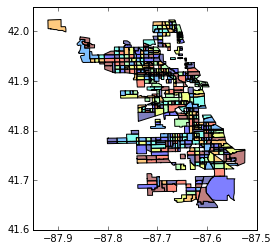

In [33]:
tracts[tracts.disjoint(grocery_stores)].plot()

**But wait: that's not what we're doing!** We're interested in (kind of) people who are **half a mile** from a grocery store.

## Which census tracts are far from a grocery store? Introducing buffer!

`.buffer()` draws a buffer around a point, line, or shape. You can use it to say, "show me things within XXX distance of YYY". Try to take the grocery stores, draw a half-mile buffer around them, and plot it.

**It won't look pretty.**

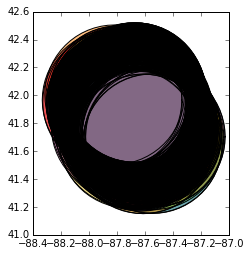

In [37]:
grocery_stores.buffer(0.5).plot()

In [38]:
grocery_stores.crs

{'init': 'epsg:4326'}

## That... doesn't work.

Unfortunately `.buffer` uses the units of the current CRS, and the current CRS is **EPSG:4326**. What units is it using? You'll need to ask Google.

## Reprojecting to be able to use meters

Luckily we can use Mercator, the projection we should all dislike because it looks so ugly, to get units of meters.

You can use the epsg of `3395` if you'd like, or use `{'proj': 'merc'}` - either one is fine.

**How many meters is half a mile?**

- Reproject grocery stores to be Mercator (permanently)
- Create a half-mile buffer, 
- and map it.

Same thing:

* `grocery_stores.to_crs({'proj': 'merc'}).buffer(800).plot()`
* `grocery_stores.to_crs(epsg=3395).buffer(800).plot()`

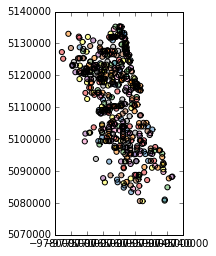

In [40]:
grocery_stores.to_crs({'proj': 'merc'}).buffer(800).plot()

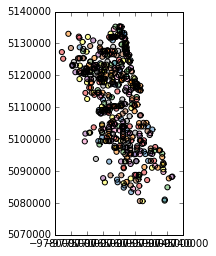

In [41]:
grocery_stores.to_crs(epsg=3395).buffer(800).plot()

In [42]:
# Let's just make everything mercator!! (meters)
# We need to do this because otherwise they won't
# be able to find each other, because tracts will
# be lat/lon and grocery stores will be thousands of meters
grocery_stores = grocery_stores.to_crs({'proj': 'merc'})
tracts = tracts.to_crs({'proj': 'merc'})

# "no system file 2" or whatever 
# means you typed ESPG 😢 
# instead of EPSG 😄
# EUROPEAN! PETROLEUM!
# SURVEY! GROUP!

## Finding our food deserts

First, make a map of **every census tract** and **every grocery store**, along with a **buffer zone** around the grocery stores. You'll need to make sure they're in the **same projection**, and you might want to save the buffer to a new variable (`buffered_grocery_stores`, maybe?). You'll also probably want the buffer zone to be plotted with `alpha=0.5` or something like that to make it a bit transparent.

Actually, just **permanently reproject `tracts` to be Mercator**.

In [49]:
# Create a buffer of 800 meters on grocery_stores
# it gives back a bunch of geometries/shapes
# in a GeoDataFrame
# so basically the 'geometry' column without the extra data
buffered_grocery_stores = grocery_stores.buffer(800)
buffered_grocery_stores.head()

0    POLYGON ((-9753119.737420607 5103981.778572024...
1    POLYGON ((-9755646.462380236 5124725.204320104...
2    POLYGON ((-9764553.711852053 5104649.938418441...
3    POLYGON ((-9762377.847771194 5103776.950972501...
4    POLYGON ((-9769557.210010724 5122108.793547577...
dtype: object

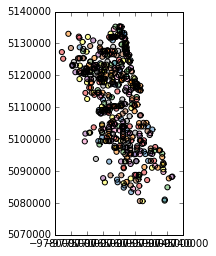

In [50]:
# .plot works just fine on it
buffered_grocery_stores.plot()

(-9790000.0, -9740000.0, 5070000.0, 5140000.0)

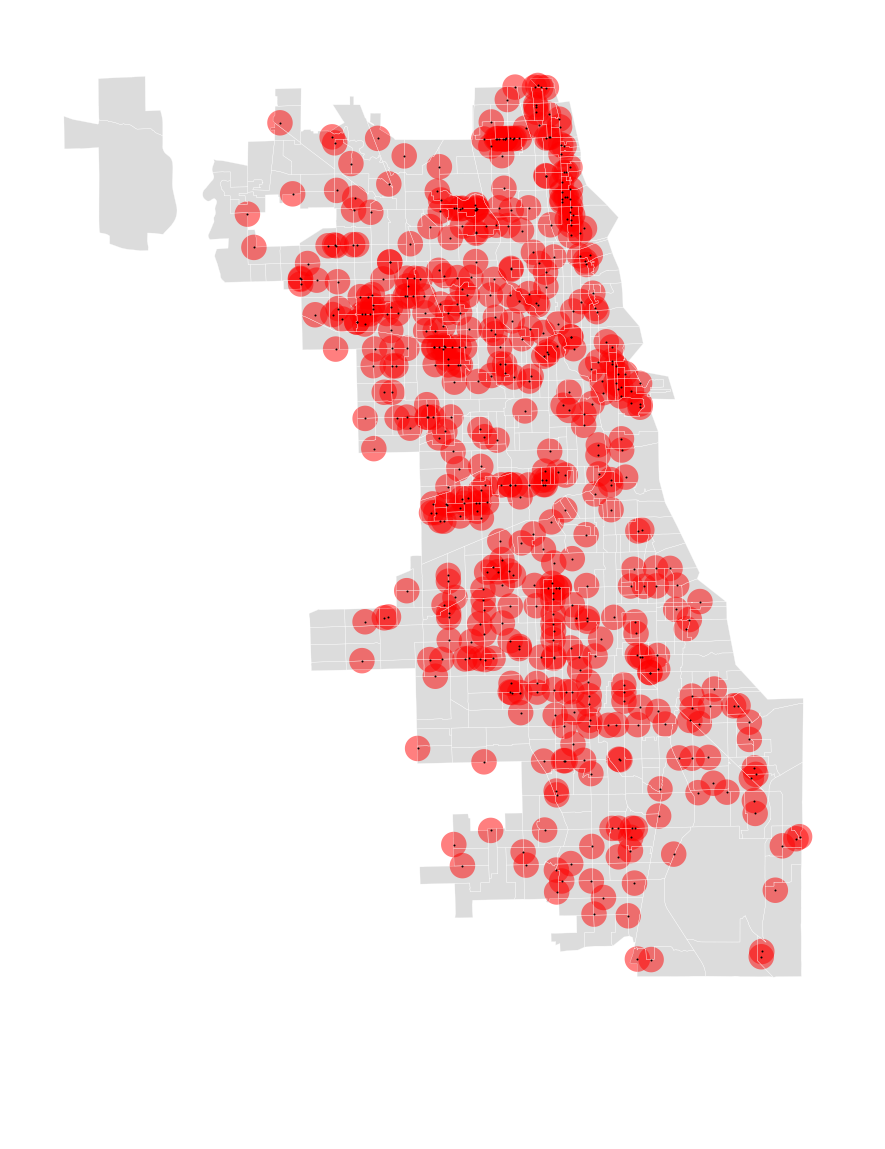

In [57]:
ax = tracts.plot(color='#BBBBBB', linewidth=0.25, edgecolor='white', figsize=(20, 20))
buffered_grocery_stores.plot(color='red', ax=ax, linewidth=0)
grocery_stores.plot(color='black', ax=ax, markeredgewidth=0)
ax.axis('off')

## Now add to that the census tracts that do NOT touch one of our buffers.

It... doesn't seem to look right, once again.

(-9790000.0, -9740000.0, 5070000.0, 5140000.0)

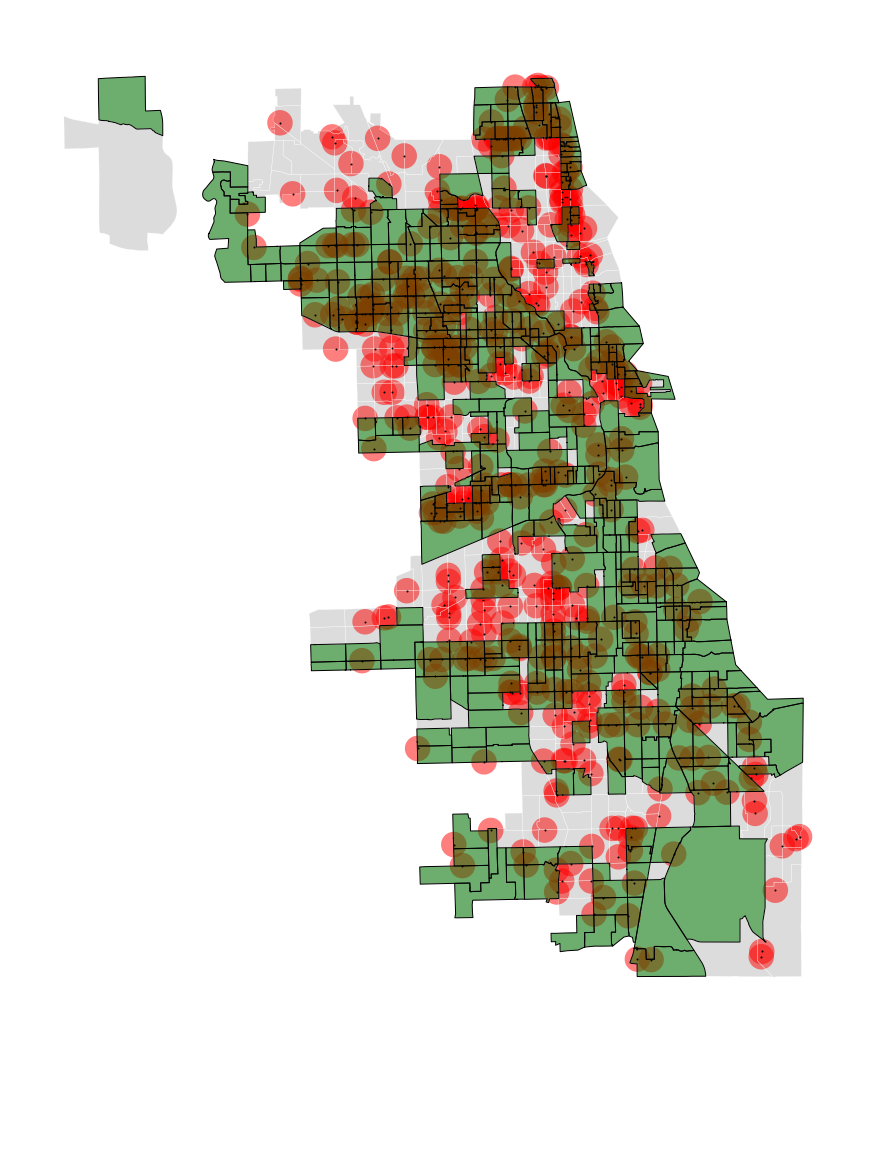

In [58]:
ax = tracts.plot(color='#BBBBBB', linewidth=0.25, edgecolor='white', figsize=(20, 20))
buffered_grocery_stores.plot(color='red', ax=ax, linewidth=0)
grocery_stores.plot(color='black', ax=ax, markeredgewidth=0)
# try to plot the tracts
# where the tracts DO NOT TOUCH the buffers AT ALL
tracts[tracts.disjoint(buffered_grocery_stores)].plot(ax=ax, color='green')
ax.axis('off')

## The sad way of doing it

If you want to do this right, we need to do it **one tract at a time**, and say "hey, do you intersect with any buffers?"

First, let's pull out a single tract.

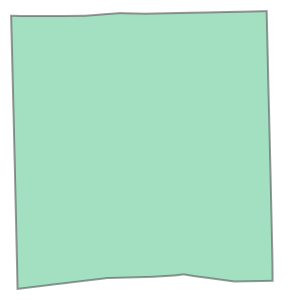

In [60]:
# Hey tracts
# give me row with the index 99
tract = tracts.loc[99]
tract.geometry

In [63]:
type(tract.geometry)

shapely.geometry.polygon.Polygon

Then, ask it which grocery store buffers it interacts with. **I'm using `.head()` so I don't have to see a big long list**.

In [69]:
# Dear grocery store buffers,
# do any of you intersect with this lonely lonely tract?
buffered_grocery_stores.intersects(tract.geometry)

0      False
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19     False
20     False
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28     False
29     False
       ...  
476    False
477    False
478    False
479    False
480    False
481    False
482    False
483    False
484    False
485    False
486    False
487    False
488    False
489    False
490    False
491    False
492    False
493    False
494    False
495    False
496    False
497    False
498    False
499    False
500    False
501    False
502    False
503    False
504    False
505    False
Length: 506, dtype: bool

Instead of a big long list of `True` and `False` for every single comparison, I can say **"hey, were any of those True?"**

In [72]:
# We have taken out ONE geometry
# and we are comparing it to EVERY grocery store buffer
buffered_grocery_stores.intersects(tract.geometry).any()

True

### Using .intersects and .any() with a .apply

So now we get to the real ugly part: go through every single tract, see if it intersects, and map accordingly.

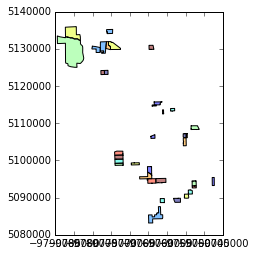

In [73]:
# returns YES if the row intersects with ANY of the grocery stores
def does_intersect(row):
    return buffered_grocery_stores.intersects(row.geometry).any()

# Go through every row, testing for an intersection
# notice the ~ to make it negative
tracts[~tracts.apply(does_intersect, axis=1)].plot()

## Stop crying, please: we can fix this with `.unary_union`

The problem right now is that we're comparing **every single tract** to **every single buffer**. But what if there was only **one buffer** instead of a few hundred?

In [78]:
buffered_grocery_stores.shape

(506,)

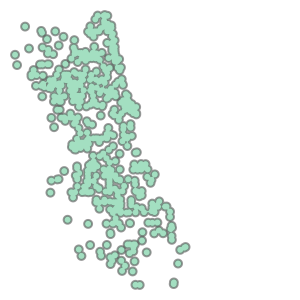

In [81]:
buffered_grocery_stores.unary_union

In [84]:
# MANY to ONE comparisons
# we have MANY tracts
# but we have ONE buffer now (because it's a union
# and we've glued them all together)
tracts.disjoint(buffered_grocery_stores.unary_union)

0      False
1      False
2      False
3      False
4      False
5      False
6      False
7      False
8      False
9      False
10     False
11     False
12     False
13     False
14     False
15     False
16     False
17     False
18     False
19     False
20     False
21     False
22     False
23     False
24     False
25     False
26     False
27     False
28     False
29     False
       ...  
771    False
772    False
773    False
774    False
775    False
776    False
777    False
778    False
779    False
780    False
781    False
782    False
783    False
784    False
785    False
786    False
787    False
788    False
789    False
790    False
791    False
792    False
793    False
794    False
795    False
796    False
797    False
798     True
799    False
800    False
Length: 801, dtype: bool

Look at that!!!! **`.unary_union`** takes a bunch of polygons or whatever and turns them into ONE NICE SIMPLE POYLGON.

And we can use that with our `.intersects` now, really super easily.

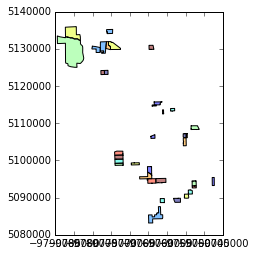

In [85]:
tracts[tracts.disjoint(buffered_grocery_stores.unary_union)].plot()

## Plot that on top of the map you made before, with all of the circles

You'll want to do it AFTER you plot all of the tracts but BEFORE you plot the grocery stores.

(-9790000.0, -9740000.0, 5070000.0, 5140000.0)

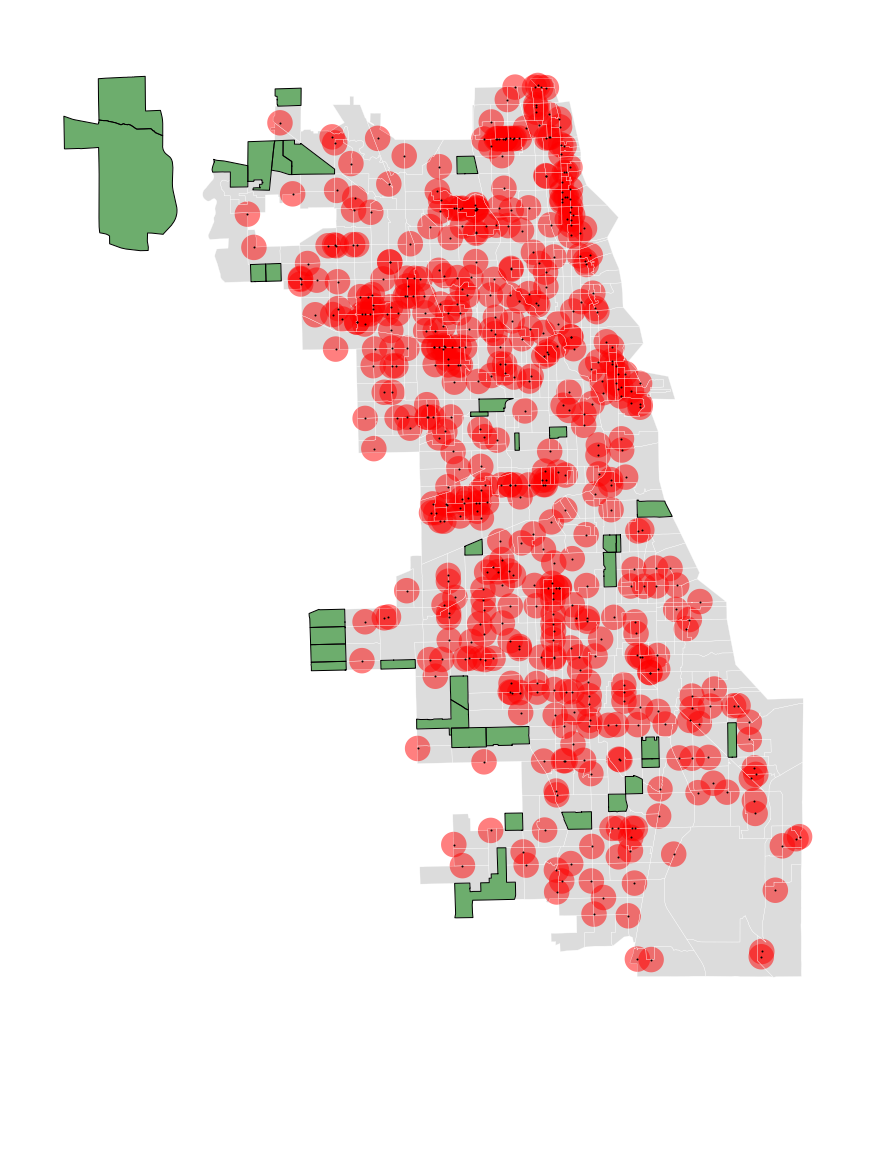

In [86]:
ax = tracts.plot(color='#BBBBBB', linewidth=0.25, edgecolor='white', figsize=(20, 20))
buffered_grocery_stores.plot(color='red', ax=ax, linewidth=0)
grocery_stores.plot(color='black', ax=ax, markeredgewidth=0)
# try to plot the tracts
# where the tracts DO NOT TOUCH the buffers AT ALL
tracts[tracts.disjoint(buffered_grocery_stores.unary_union)].plot(ax=ax, color='green')
ax.axis('off')

## Okay actually though I have bad news

Usually when you do these comparisons, you aren't saying "does ANY part of this census tract touch a buffer zone," you're saying "does the CENTER of this census tract touch a buffer zone?"

**How do we find the center of the census tracts?** It isn't terrible, really.

## Getting the center of the census tracts

The important thing is that they aren't called centers, they're called **centroids**.

And you find them by just typing....... `centroid`.

In [90]:
tracts.centroid.head()

0    POINT (-9754931.488121599 5094025.722640746)
1    POINT (-9760702.447700242 5107355.596141564)
2    POINT (-9755494.456942635 5110170.881676532)
3    POINT (-9760864.979118472 5110849.228339726)
4    POINT (-9759945.189688148 5113061.217586301)
dtype: object

In [94]:
tracts[~tracts.centroid.within(buffered_grocery_stores.unary_union)]

,commarea,commarea_n,countyfp10,geoid10,geometry,name10,namelsad10,notes,statefp10,tractce10
0,44,44.0,031,17031842400,POLYGON ((-9754264.404603189 5092203.790407264...,8424,Census Tract 8424,None,17,842400
4,28,28.0,031,17031838200,POLYGON ((-9759137.081353614 5113622.448989172...,8382,Census Tract 8382,None,17,838200
6,53,53.0,031,17031530503,POLYGON ((-9756470.311632894 5082251.334041915...,5305.03,Census Tract 5305.03,None,17,530503
7,76,76.0,031,17031760803,POLYGON ((-9778130.635519065 5127934.234250993...,7608.03,Census Tract 7608.03,None,17,760803
8,54,54.0,031,17031540102,POLYGON ((-9753686.099848988 5081242.962023841...,5401.02,Census Tract 5401.02,None,17,540102
9,54,54.0,031,17031540101,POLYGON ((-9753693.224295937 5081240.438634574...,5401.01,Census Tract 5401.01,None,17,540101
10,44,44.0,031,17031440201,"POLYGON ((-9752962.18920397 5094501.675737101,...",4402.01,Census Tract 4402.01,None,17,440201
15,29,29.0,031,17031843300,POLYGON ((-9761407.665008919 5111411.345570057...,8433,Census Tract 8433,None,17,843300
20,67,67.0,031,17031834900,POLYGON ((-9757649.519000923 5099301.819981472...,8349,Census Tract 8349,None,17,834900
24,35,35.0,031,17031842000,POLYGON ((-9754821.669973642 5108275.256741182...,8420,Census Tract 8420,None,17,842000


## Which centroids aren't inside of a buffer?

Well, we do the exact same as before, but we ask something like "which centroids are NOT within the grocery store buffer zone?", and then we feed that right back to `tracts`.

## And then we just map it all over again

(-9790000.0, -9740000.0, 5070000.0, 5140000.0)

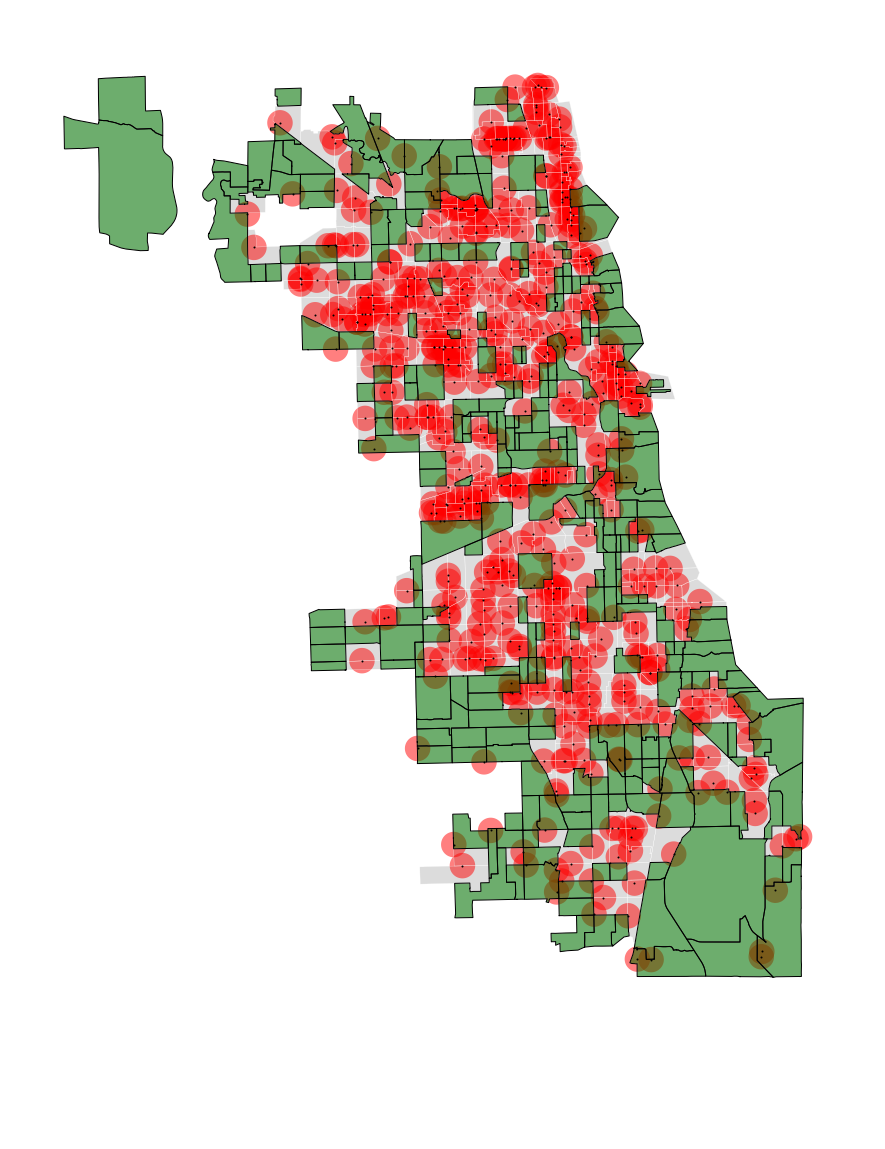

In [95]:
ax = tracts.plot(color='#BBBBBB', linewidth=0.25, edgecolor='white', figsize=(20, 20))
buffered_grocery_stores.plot(color='red', ax=ax, linewidth=0)
grocery_stores.plot(color='black', ax=ax, markeredgewidth=0)
# try to plot the tracts
# where the tract centroids are not inside of the buffer
tracts[~tracts.centroid.within(buffered_grocery_stores.unary_union)].plot(ax=ax, color='green')
ax.axis('off')

## And if we want to get technical and make your brain hurt more

There are two kinds of grocery stores, A and B, and B should have a half-mile radius and A should have a one-mile radius.

In [ ]:
def make_fancy_buffer(row):
    if row['BUFFER SIZE'] == 'A':
        return row.geometry.buffer(1600)
    elif row['BUFFER SIZE'] == 'B':
        return row.geometry.buffer(800)
    
fancy_buffer = grocery_stores.apply(make_fancy_buffer, axis=1)

# We need to convert it into a GeoSeries because pandas thinks its a normal series
fancy_buffer = gpd.GeoSeries(fancy_buffer)

### Make the many-layered map again, but this time use `fancy_buffer` instead of `grocery_stores_buffer`